In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

In [36]:
# Define batch specifications
batch_size = 32
img_height = 250
img_width = 250


In [37]:
# Load training, validation, and testing datasets
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    
    'C:\\Users\\acs\\Downloads\\archive (3)\\data\\train',
    seed=42,
    
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)


Found 791 files belonging to 2 classes.


In [38]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    'C:\\Users\\acs\\Downloads\\archive (3)\\data\\val',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'C:\\Users\\acs\\Downloads\\archive (3)\\data\\test',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [39]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [40]:
# Configure datasets for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
# Create EfficientDet model
def create_efficientdet_model(input_shape, num_classes):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Fine-tune pre-trained weights

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [42]:
# Create EfficientDet model instance
input_shape = (img_height, img_width, 3)
num_classes = 2  # Number of classes (Accident, Non-Accident)
efficientdet_model = create_efficientdet_model(input_shape, num_classes)

In [43]:
# Compile the model
efficientdet_model.compile(optimizer=Adam(),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

# Model summary
efficientdet_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 4052133 (15.46 MB)
Trainable params: 4010110 (15.30 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [44]:
# Train the model
checkpoint = ModelCheckpoint("efficientdet_model_weights.h5",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

        
callbacks_list = [checkpoint]
history = efficientdet_model.fit(training_data,
                                 validation_data=validation_data,
                                 epochs=5,
                                 callbacks=callbacks_list)

Epoch 1/5
25/25 [==============================] - ETA: 0s - loss: 0.5248 - accuracy: 0.7408  
Epoch 1: val_accuracy improved from -inf to 0.88776, saving model to efficientdet_model_weights.h5


c:\Users\acs\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 2789s 111s/step - loss: 0.5248 - accuracy: 0.7408 - val_loss: 0.2799 - val_accuracy: 0.8878
Epoch 2/5
25/25 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9077  
Epoch 2: val_accuracy improved from 0.88776 to 0.90816, saving model to efficientdet_model_weights.h5
25/25 [==============================] - 4119s 163s/step - loss: 0.2372 - accuracy: 0.9077 - val_loss: 0.3199 - val_accuracy: 0.9082
Epoch 3/5
25/25 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9267  
Epoch 3: val_accuracy improved from 0.90816 to 0.91837, saving model to efficientdet_model_weights.h5
25/25 [==============================] - 4261s 171s/step - loss: 0.1950 - accuracy: 0.9267 - val_loss: 0.2388 - val_accuracy: 0.9184
Epoch 4/5
25/25 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.9621  
Epoch 4: val_accuracy did not improve from 0.91837
25/25 [==============================] - 3987s 160s/step - lo

In [46]:
# Serialize model structure to JSON
model_json = efficientdet_model.to_json()
with open("efficientdet_model.json", "w") as json_file:
    json_file.write(model_json)

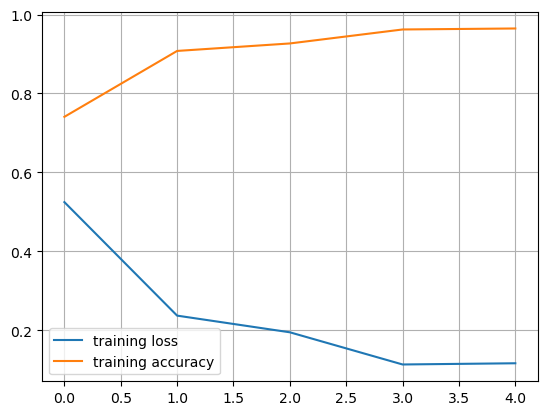

In [47]:
# Plot training 
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.grid(True)
plt.legend()




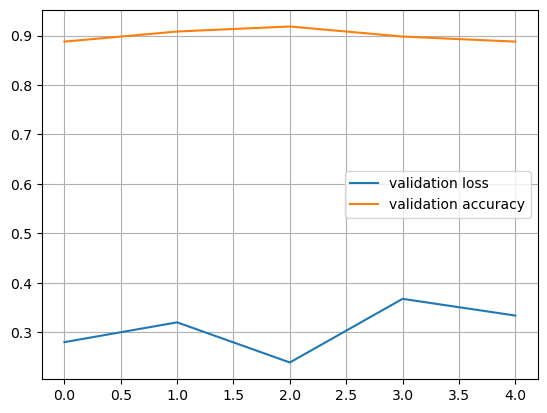

In [48]:
# Plot validation 
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.grid(True)
plt.legend()

1/1 [==============================] - 7s 7s/step


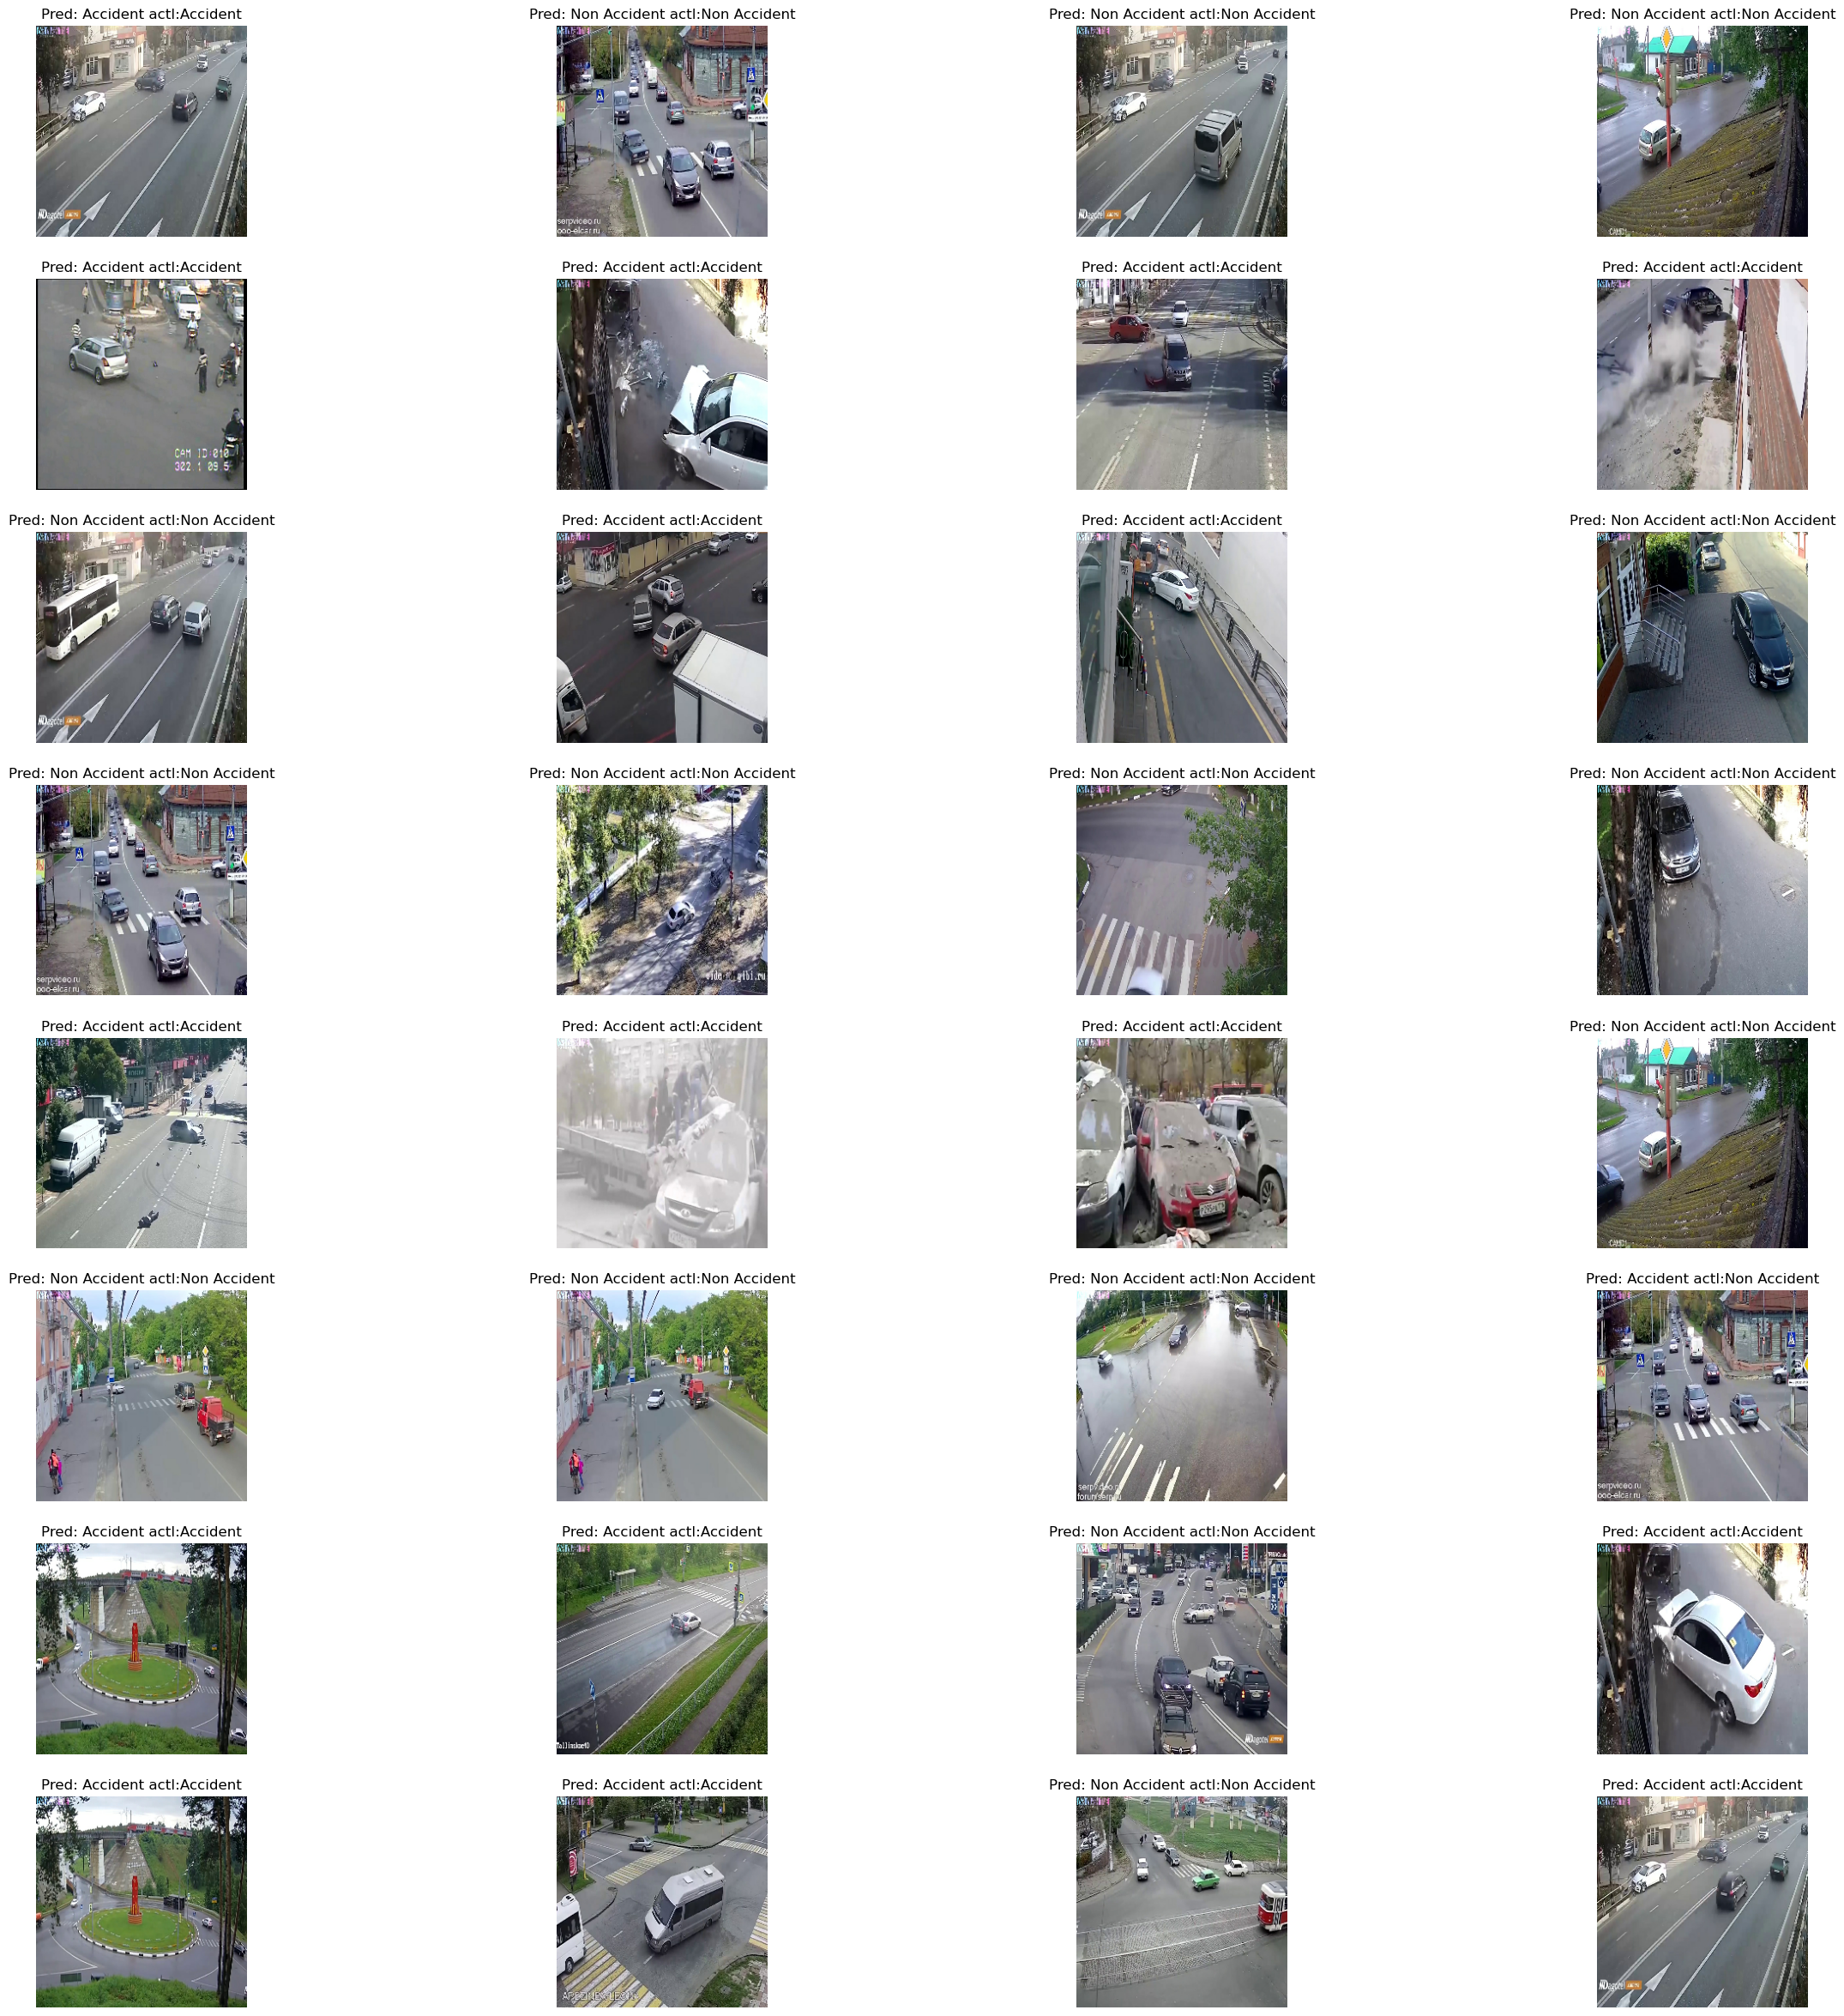

In [50]:

# Visualize results on testing data
AccuracyVector = []
plt.figure(figsize=(30, 30))

# Iterate over the testing dataset
for images, labels in testing_data:
    predictions = efficientdet_model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(len(images)):  # Iterate over the batch size
        ax = plt.subplot(8, 4, i + 1)  # Adjust subplot layout if needed
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [45]:
# Evaluate the model on the testing dataset
loss, accuracy = efficientdet_model.evaluate(testing_data)
print("Testing Accuracy:", accuracy)



 
 

  




    

4/4 [==============================] - 21s 4s/step - loss: 0.1570 - accuracy: 0.9500
Testing Accuracy: 0.949999988079071


In [ ]:
import cv2
from keras.models import model_from_json
import numpy as np
import winsound
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

class AccidentDetectionModel(object):

    class_nums = ['Accident', "No Accident"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_accident(self, img):
        self.preds = self.loaded_model.predict(img)
        return AccidentDetectionModel.class_nums[np.argmax(self.preds)], self.preds


def detect_accident(video_path, label):
    model = AccidentDetectionModel("efficientdet_model.json", 'efficientdet_model_weights.h5')
    font = cv2.FONT_HERSHEY_SIMPLEX
    cap = cv2.VideoCapture(video_path)
    
    frame_count = 0
    skip_frames = 5  
    beep_count = 0  
    
    while True:
        ret, frame = cap.read()
        
        # Skip frames
        if frame_count % skip_frames != 0:
            frame_count += 1
            continue
        
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(gray_frame, (250, 250))

        pred, _ = model.predict_accident(roi[np.newaxis, :, :])
        if pred == "Accident":
            
            winsound.Beep(1000, 500)  
            
            cv2.rectangle(frame, (0, 0), (280, 40), (0, 0, 0), -1)
            cv2.putText(frame, "Accident Detected", (20, 30), font, 1, (255, 255, 0), 2)
            
            
            beep_count = 0

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frame = ImageTk.PhotoImage(image=frame)

        label.config(image=frame)
        label.image = frame

        label.update()  
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


def open_file_dialog(root, label):
    file_path = filedialog.askopenfilename()
    if file_path:
        detect_accident(file_path, label)

def stop_execution(root):
    root.destroy()

def main():
    root = tk.Tk()
    root.title("Automatic Accident Detection")
    root.configure(bg='#7FB3D5') 

    def enter():
        root.destroy()
        page2()

    tk.Label(root, text="Automatic Accident Detection", font=("Helvetica", 20), bg='#7FB3D5', fg='white').pack(pady=20)
    tk.Button(root, text="Enter ", command=enter, font=("Helvetica", 16), bg='#2ecc71', fg='white').pack()

    root.mainloop()

def page2():
    root = tk.Tk()
    root.title("Accident Detection")
    root.configure(bg='#7FB3D5') 

    label = tk.Label(root)
    label.pack(pady=10)

    def detect():
        open_file_dialog(root, label)

    def exit_app():
        root.destroy()

    tk.Label(root, text="Select an option:", font=("Helvetica", 20), bg='#7FB3D5', fg='white').pack(pady=20)
    tk.Button(root, text="Detect", command=detect, font=("Helvetica", 16), bg='#2ecc71', fg='white').pack(pady=10)
    tk.Button(root, text="Exit", command=exit_app, font=("Helvetica", 16), bg='#e74c3c', fg='white').pack(pady=10)

    root.mainloop()

if __name__ == '__main__':
    main()
